In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

In [3]:
data =pd.read_csv('lending_club_loan_two.csv')

In [4]:
imputer = SimpleImputer(strategy='most_frequent')
data['emp_title'].fillna("Unknown", inplace=True)  # Filling text NaNs with 'Unknown'
data['emp_length'].fillna("0 years", inplace=True)
data[['revol_util', 'mort_acc', 'pub_rec_bankruptcies']] = imputer.fit_transform(data[['revol_util', 'mort_acc', 'pub_rec_bankruptcies']])

data['term'] = data['term'].apply(lambda x: int(x.strip().split()[0]))  # Extract the numeric part
label_enc_cols = ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'initial_list_status', 'application_type']

for col in label_enc_cols:
    data[col] = LabelEncoder().fit_transform(data[col])

In [5]:
def clean_emp_length(emp_length):
    if emp_length == '< 1 year':
        return 0
    elif emp_length == '10+ years':
        return 10
    else:
        try:
            return int(emp_length.split()[0])
        except:
            return 0  # Default to 0 if any issues

data['emp_length'] = data['emp_length'].apply(clean_emp_length)

In [6]:
loan_data = pd.read_csv('lending_club_loan_two.csv')

# Map target variable
loan_data['loan_status'] = loan_data['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})
loan_data = loan_data.dropna(subset=['loan_status'])

In [7]:
# Fill missing values with mean for only numeric columns
loan_data = loan_data.fillna(loan_data.select_dtypes(include=['float64', 'int64']).mean())


In [8]:
# Fill missing values for numeric columns with the mean and categorical columns with the mode
for column in loan_data.columns:
    if loan_data[column].dtype in ['float64', 'int64']:
        loan_data[column].fillna(loan_data[column].mean(), inplace=True)
    else:
        loan_data[column].fillna(loan_data[column].mode()[0], inplace=True)

In [9]:
# One-hot encoding categorical features in one go
loan_data = pd.get_dummies(loan_data, columns=['term', 'grade', 'sub_grade', 'home_ownership', 
                                               'verification_status', 'application_type'], drop_first=True)


In [10]:
# Fill missing values only in numeric columns used in the model
loan_data[loan_data.select_dtypes(include=['float64', 'int64']).columns] = loan_data.select_dtypes(
    include=['float64', 'int64']).apply(lambda col: col.fillna(col.mean()))


In [11]:
#from sklearn.preprocessing import LabelEncoder

# Re-define LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical features safely, ensuring 'term' and others are correctly handled
for col in ['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'application_type']:
    if col in loan_data.columns:
        loan_data[col] = label_encoder.fit_transform(loan_data[col].astype(str))

# Confirm preprocessing adjustment by displaying sample data
loan_data.head()


,loan_amnt,int_rate,installment,emp_title,emp_length,annual_inc,issue_d,loan_status,purpose,title,...,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,application_type_INDIVIDUAL,application_type_JOINT
0,10000.0,11.44,329.48,Marketing,10+ years,117000.0,Jan-2015,0,vacation,Vacation,...,False,False,False,False,False,True,False,False,True,False
1,8000.0,11.99,265.68,Credit analyst,4 years,65000.0,Jan-2015,0,debt_consolidation,Debt consolidation,...,False,True,False,False,False,False,False,False,True,False
2,15600.0,10.49,506.97,Statistician,< 1 year,43057.0,Jan-2015,0,credit_card,Credit card refinancing,...,False,False,False,False,False,True,True,False,True,False
3,7200.0,6.49,220.65,Client Advocate,6 years,54000.0,Nov-2014,0,credit_card,Credit card refinancing,...,False,False,False,False,False,True,False,False,True,False
4,24375.0,17.27,609.33,Destiny Management Inc.,9 years,55000.0,Apr-2013,1,credit_card,Credit Card Refinance,...,False,True,False,False,False,False,False,True,True,False


In [12]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [13]:
# Define target variable
y = loan_data['loan_status']

# Feature sets for each model
rf_features = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'revol_bal', 
               'revol_util', 'open_acc', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies'] + \
               [col for col in loan_data.columns if col.startswith('sub_grade_')]


nn_features = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'total_acc', 'mort_acc', 
               'revol_bal', 'pub_rec_bankruptcies'] + [col for col in loan_data.columns if col.startswith('home_ownership_')]

knn_features = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_util', 'open_acc', 'mort_acc']


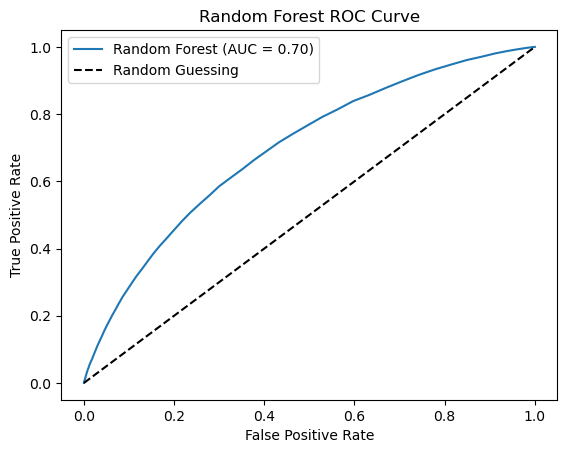

In [19]:
# Random Forest
X_rf = loan_data[rf_features]
X_train_rf, X_test_rf, y_train, y_test = train_test_split(X_rf, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_rf, y_train)

# ROC Curve for Random Forest
fpr, tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test_rf)[:,1])
plt.figure()
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")  # Reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.title("Random Forest ROC Curve")
plt.show()


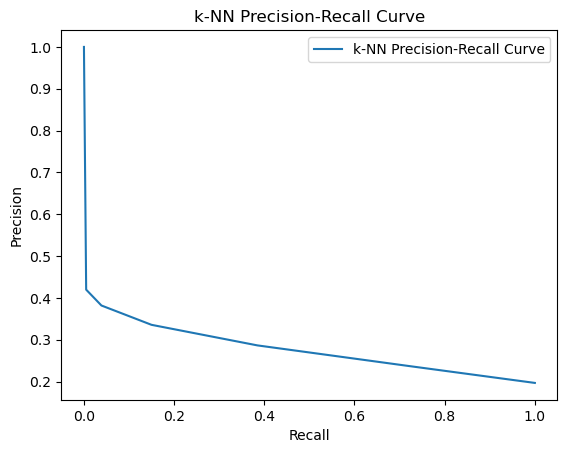

In [16]:
from sklearn.metrics import precision_recall_curve


# k-Nearest Neighbors
X_knn = loan_data[knn_features]
X_train_knn, X_test_knn, y_train, y_test = train_test_split(X_knn, y, test_size=0.3, random_state=42)

# Initialize scaler and apply to data
scaler = StandardScaler()
X_train_knn = scaler.fit_transform(X_train_knn)
X_test_knn = scaler.transform(X_test_knn)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_knn, y_train)

# Precision-Recall Curve for k-NN
y_scores_knn = knn_model.predict_proba(X_test_knn)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores_knn)
plt.figure()
plt.plot(recall, precision, label="k-NN Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("k-NN Precision-Recall Curve")
plt.show()



/Users/shamilinalluri/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


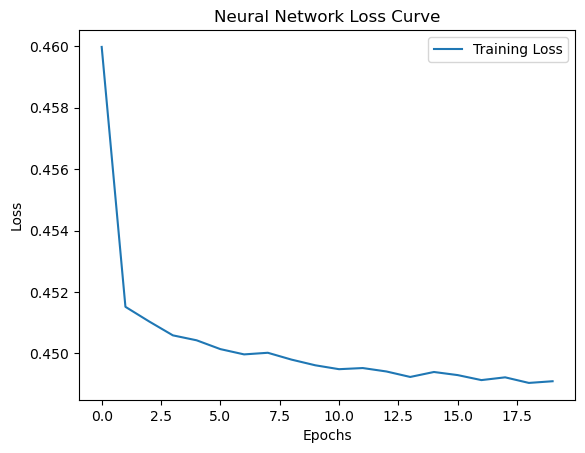

In [24]:
# Neural Network
X_nn = loan_data[nn_features]
X_train_nn, X_test_nn, y_train, y_test = train_test_split(X_nn, y, test_size=0.3, random_state=42)

X_train_nn = scaler.fit_transform(X_train_nn)
X_test_nn = scaler.transform(X_test_nn)

nn_model = MLPClassifier(random_state=42, max_iter=100)
history = nn_model.fit(X_train_nn, y_train)

# Loss Curve for Neural Network
plt.figure()
plt.plot(nn_model.loss_curve_, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Neural Network Loss Curve")
plt.legend()
plt.show()
